📈 Classificação de Dias de Alta ou Baixa no Ibovespa com Regressão Logística
Este notebook tem como objetivo aplicar um modelo de classificação binária utilizando Regressão Logística para prever se o índice Ibovespa terá um dia de alta (1) ou baixa (0) com base em variáveis históricas dos últimos 4 anos.

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


pandas / numpy: Manipulação de dados.

sklearn: Algoritmos de Machine Learning e métricas de avaliação.

matplotlib / seaborn: Visualização de gráficos e matrizes de confusão.


📥 Leitura e Pré-processamento dos Dados

In [30]:
df_ibovespa = pd.read_csv("Historico_4_Anos_Ibovespa.csv", sep = ",", decimal = ",")
#O arquivo  utiliza , como separador e , como separador decimal (padrão brasileiro).

🔧 Tratamento de Dados
1. Conversão de Variáveis Percentuais e Volumes

In [31]:
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str[:-1]
df_ibovespa['Var%'] = df_ibovespa['Var%'].str[:-1]
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace(',','.')
df_ibovespa['Var%'] = df_ibovespa['Var%'].str.replace(',','.')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].astype(float)
df_ibovespa['Var%'] = df_ibovespa['Var%'].astype(float)
#Remove-se o símbolo % das colunas Vol. e Var% e converte-se para float.


2. Conversão de Datas

In [32]:
df_ibovespa["Data"] = pd.to_datetime(df_ibovespa["Data"], format="%d.%m.%Y")
#Transforma a coluna de datas para o formato datetime.

3. Conversão de Strings Numéricas

In [33]:
df_ibovespa["Último"] = df_ibovespa["Último"].str.replace(".", "").astype(float)
df_ibovespa["Abertura"] = df_ibovespa["Abertura"].str.replace(".", "").astype(float)
df_ibovespa["Máxima"] = df_ibovespa["Máxima"].str.replace(".", "").astype(float)
df_ibovespa["Mínima"] = df_ibovespa["Mínima"].str.replace(".", "").astype(float)
#Remove pontos separadores de milhar e converte para float.

📊 Criação de Novas Variáveis
1. Média Móvel de 2 dias

In [34]:
df_ibovespa['MM2'] = df_ibovespa['Último'].rolling(window=2).mean()
# Aplica média móvel simples (janela = 2) para reduzir volatilidade intradiária em preços de fechamento.

2. Ordenação Cronológica

In [35]:
df_ibovespa = df_ibovespa.sort_values('Data')
#Garante que os dados estejam ordenados pela data.

3. Criação de Lags (valores do dia anterior)

In [36]:
df_ibovespa['Abertura_d-1'] = df_ibovespa['Abertura'].shift(1)
df_ibovespa['Máxima_d-1'] = df_ibovespa['Máxima'].shift(1)
df_ibovespa['Mínima_d-1'] = df_ibovespa['Mínima'].shift(1)
df_ibovespa["Último_d-1"] = df_ibovespa["Último"].shift(1)
#Cria colunas com os valores de abertura, máxima, mínima e fechamento do dia anterior para usar como preditores.

4. Criação da Variável Alvo (Target)

In [37]:
def categoriza_dia(df_var_dia):
    if df_var_dia > 0:
        return "1"
    else:
        return "0"

df_ibovespa["Target"] = df_ibovespa["Var%"].apply(categoriza_dia)
#Se o valor da variação diária (Var%) for positivo, a variável Target recebe 1 (alta), senão 0 (baixa).

🧼 Limpeza de Dados e Renomeação de Colunas
1. Verificando Valores Nulos

In [38]:
print(df_ibovespa.isnull().sum())
#Verifica quantos valores nulos existem em cada coluna do DataFrame.

Data            0
Último          0
Abertura        0
Máxima          0
Mínima          0
Vol.            0
Var%            0
MM2             1
Abertura_d-1    1
Máxima_d-1      1
Mínima_d-1      1
Último_d-1      1
Target          0
dtype: int64


2. Remoção de Registros com Valores Ausentes

In [39]:
df_ibovespa = df_ibovespa.dropna()
#Remove todas as linhas que contenham valores nulos. Isso é importante para evitar falhas nos modelos de Machine Learning e visualizações posteriores.

3. Visualização dos Dados após a Limpeza

In [40]:
df_ibovespa.head()
#Exibe as primeiras 5 linhas para conferência após a limpeza.

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,MM2,Abertura_d-1,Máxima_d-1,Mínima_d-1,Último_d-1,Target
746,2022-07-04,98609.0,98952.0,99353.0,98264.0,6.28,-0.35,98452.0,98542.0,99340.0,97231.0,98954.0,0
745,2022-07-05,98295.0,98608.0,98608.0,96499.0,13.36,-0.32,98507.0,98952.0,99353.0,98264.0,98609.0,0
744,2022-07-06,98719.0,98294.0,99141.0,97423.0,13.35,0.43,99724.5,98608.0,98608.0,96499.0,98295.0,1
743,2022-07-07,100730.0,98722.0,101420.0,98722.0,12.70,2.04,100509.5,98294.0,99141.0,97423.0,98719.0,1
742,2022-07-08,100289.0,100732.0,101577.0,99958.0,9.73,-0.44,99250.5,98722.0,101420.0,98722.0,100730.0,0


4. Renomeando as Colunas para Padrão Simplificado

In [41]:
df_ibovespa.columns = [
    'dia', 
    'fechamento', 
    'abertura', 
    'max', 
    'min', 
    'volume', 
    'variacao', 
    'media_dois_dias', 
    'abertura_ontem', 
    'max_ontem', 
    'min_ontem', 
    'fechamento_ontem', 
    'target'
]
#Renomeia as colunas para nomes mais curtos e consistentes, facilitando a leitura e o uso durante a análise e modelagem.

📊 Análise Exploratória da Variação Diária
1. Identificando Variações Extrema

In [42]:
print(f'Variação máxima (%): {df_ibovespa.variacao.max()}')
print(df_ibovespa.loc[df_ibovespa.variacao == df_ibovespa.variacao.max()]['dia'])

print('\n')

print(f'Variação mínima (%): {df_ibovespa.variacao.min()}')
print(df_ibovespa.loc[df_ibovespa.variacao == df_ibovespa.variacao.min()]['dia'])

#Máxima variação diária: mostra o maior percentual de alta registrado.
#Mínima variação diária: mostra o maior percentual de queda registrado.
#Também identifica em qual data essas variações ocorreram.

Variação máxima (%): 5.54
682   2022-10-03
Name: dia, dtype: datetime64[ns]


Variação mínima (%): -3.35
656   2022-11-10
Name: dia, dtype: datetime64[ns]


2. Visualizando a Variação Diária ao Longo do Tempo

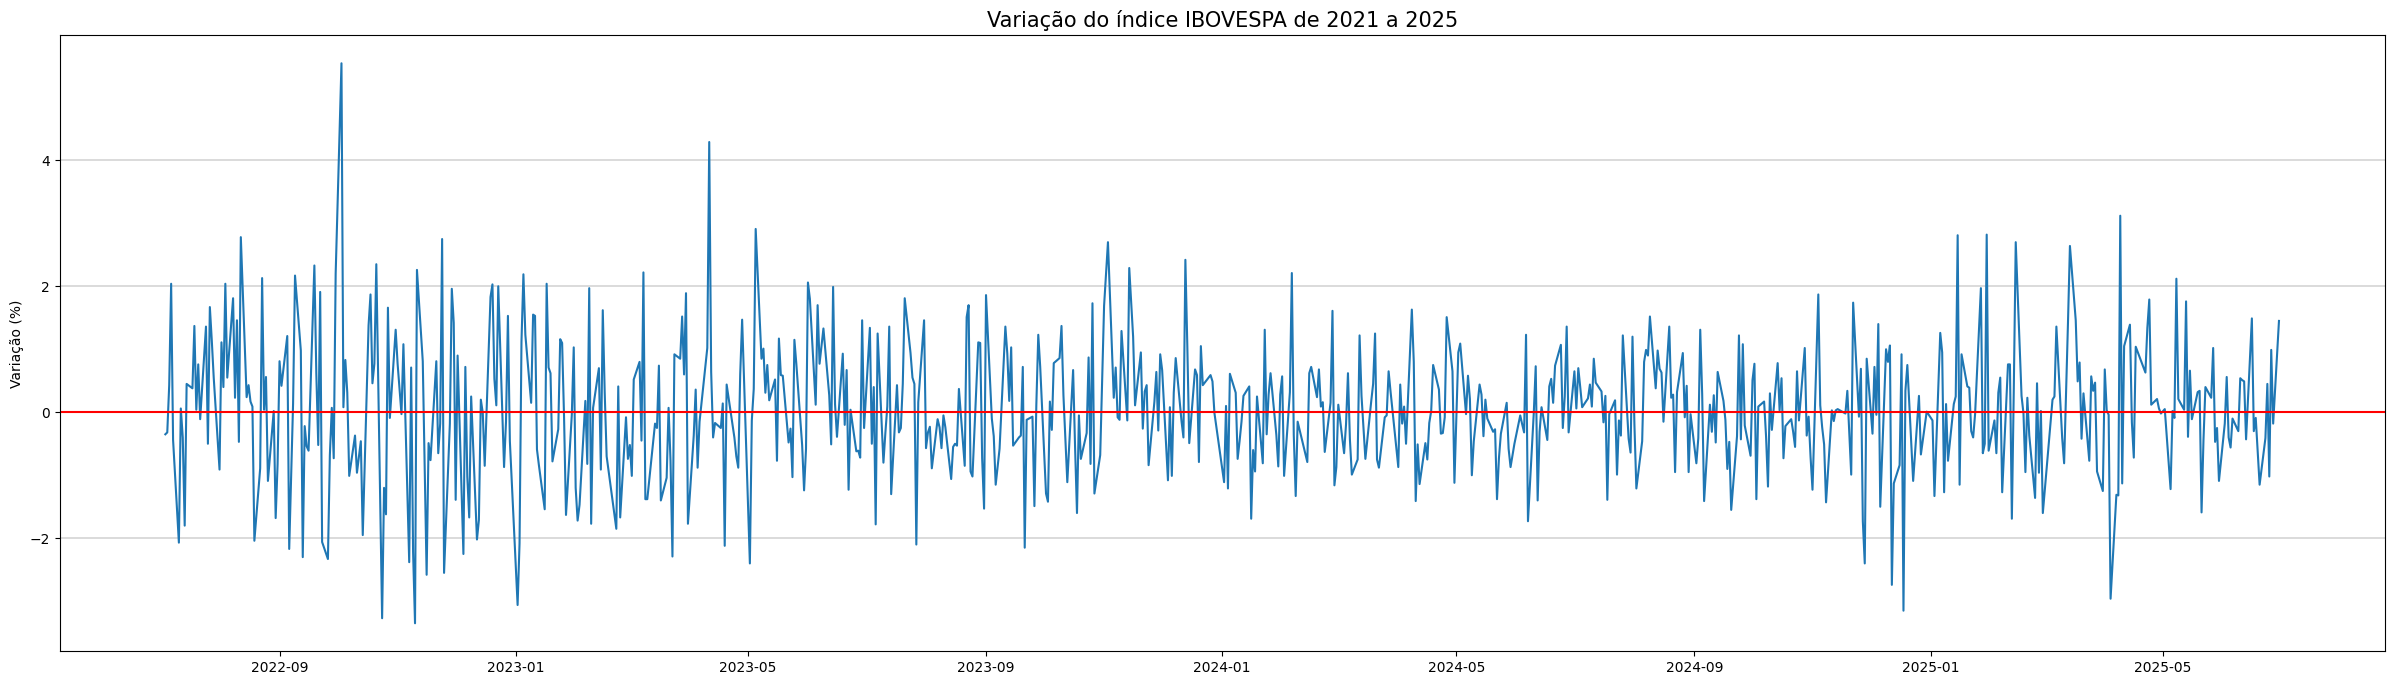

In [43]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df_ibovespa, x='dia', y='variacao', ax=ax)
ax.axhline(y=0, color='red')  # Linha horizontal no zero
ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do índice IBOVESPA de 2021 a 2025', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Variação (%)')

plt.show()

#Cria um gráfico de linha com a variação percentual diária do índice.
#A linha vermelha em y=0 indica o ponto neutro (sem variação).
#A visualização ajuda a identificar picos de alta ou queda, bem como padrões sazonais ou anomalias.

## 📈 Visão Geral da Variação do Ibovespa ao Longo do Tempo

A análise da **variação percentual diária** do índice Ibovespa entre 2021 e 2025 revela alguns padrões importantes:

- **Poucos eventos extremos**: Observa-se que apenas **raramente a variação ultrapassa a marca de 4%**, indicando que grandes oscilações são exceções e não a norma.
  
- **Estabilidade geral**: A **média global de variação se mantém próxima de 0%**, o que sugere uma tendência de **equilíbrio entre dias de alta e de baixa** ao longo do período analisado.
  
- **Confirmação visual**: Essa percepção é reforçada tanto pela distribuição dos dados no gráfico de linha quanto por análises complementares, como o gráfico de barras que compara a frequência de dias positivos (alta) e negativos (baixa). A proporção entre eles é equilibrada, evidenciando uma **volatilidade controlada** no comportamento do índice no período.

Essa tendência de estabilidade é importante para investidores que buscam avaliar o risco de exposição ao mercado durante o intervalo analisado.


## 📉 Distribuição dos Valores de Fechamento do Ibovespa (2021–2025)

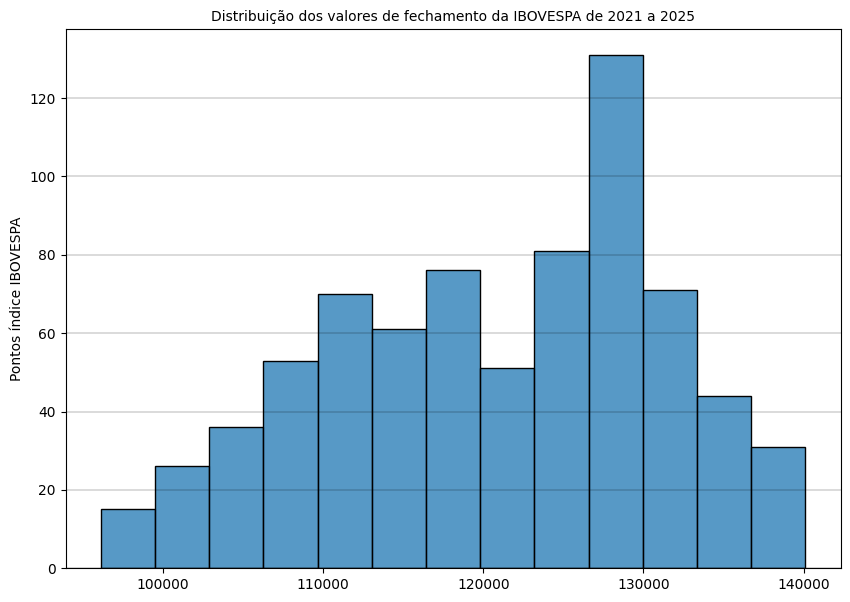

In [44]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(df_ibovespa, x='fechamento', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Distribuição dos valores de fechamento da IBOVESPA de 2021 a 2025', fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

🔎 Análise
A distribuição dos valores de fechamento do índice Ibovespa ao longo dos últimos 4 anos revela um comportamento estável e concentrado em uma faixa bem definida:

A maioria dos pregões encerrou com o índice entre 110 mil e 133 mil pontos.

Dentro dessa faixa, nota-se uma maior concentração de dias com fechamento entre 127 mil e 130 mil pontos, indicando uma zona recorrente de estabilidade ou equilíbrio do mercado.

O histograma demonstra que, apesar da volatilidade natural do mercado, o Ibovespa apresentou poucas oscilações extremas fora dessa faixa, o que pode ser interpretado como um comportamento moderado e previsível durante o período analisado.

## 📊 Análise dos Fechamentos do Índice Ibovespa (2021–2025)

In [45]:

print(f'Índice máximo no fechamento: {df_ibovespa.fechamento.max()}')
print(df_ibovespa.loc[df_ibovespa.fechamento == df_ibovespa.fechamento.max()]['dia'])

print('\n')

print(f'Índice máximo no fechamento: {df_ibovespa.fechamento.min()}')
print(df_ibovespa.loc[df_ibovespa.fechamento == df_ibovespa.fechamento.min()]['dia'])

Índice máximo no fechamento: 140110.0
29   2025-05-20
Name: dia, dtype: datetime64[ns]


Índice máximo no fechamento: 96121.0
738   2022-07-14
Name: dia, dtype: datetime64[ns]


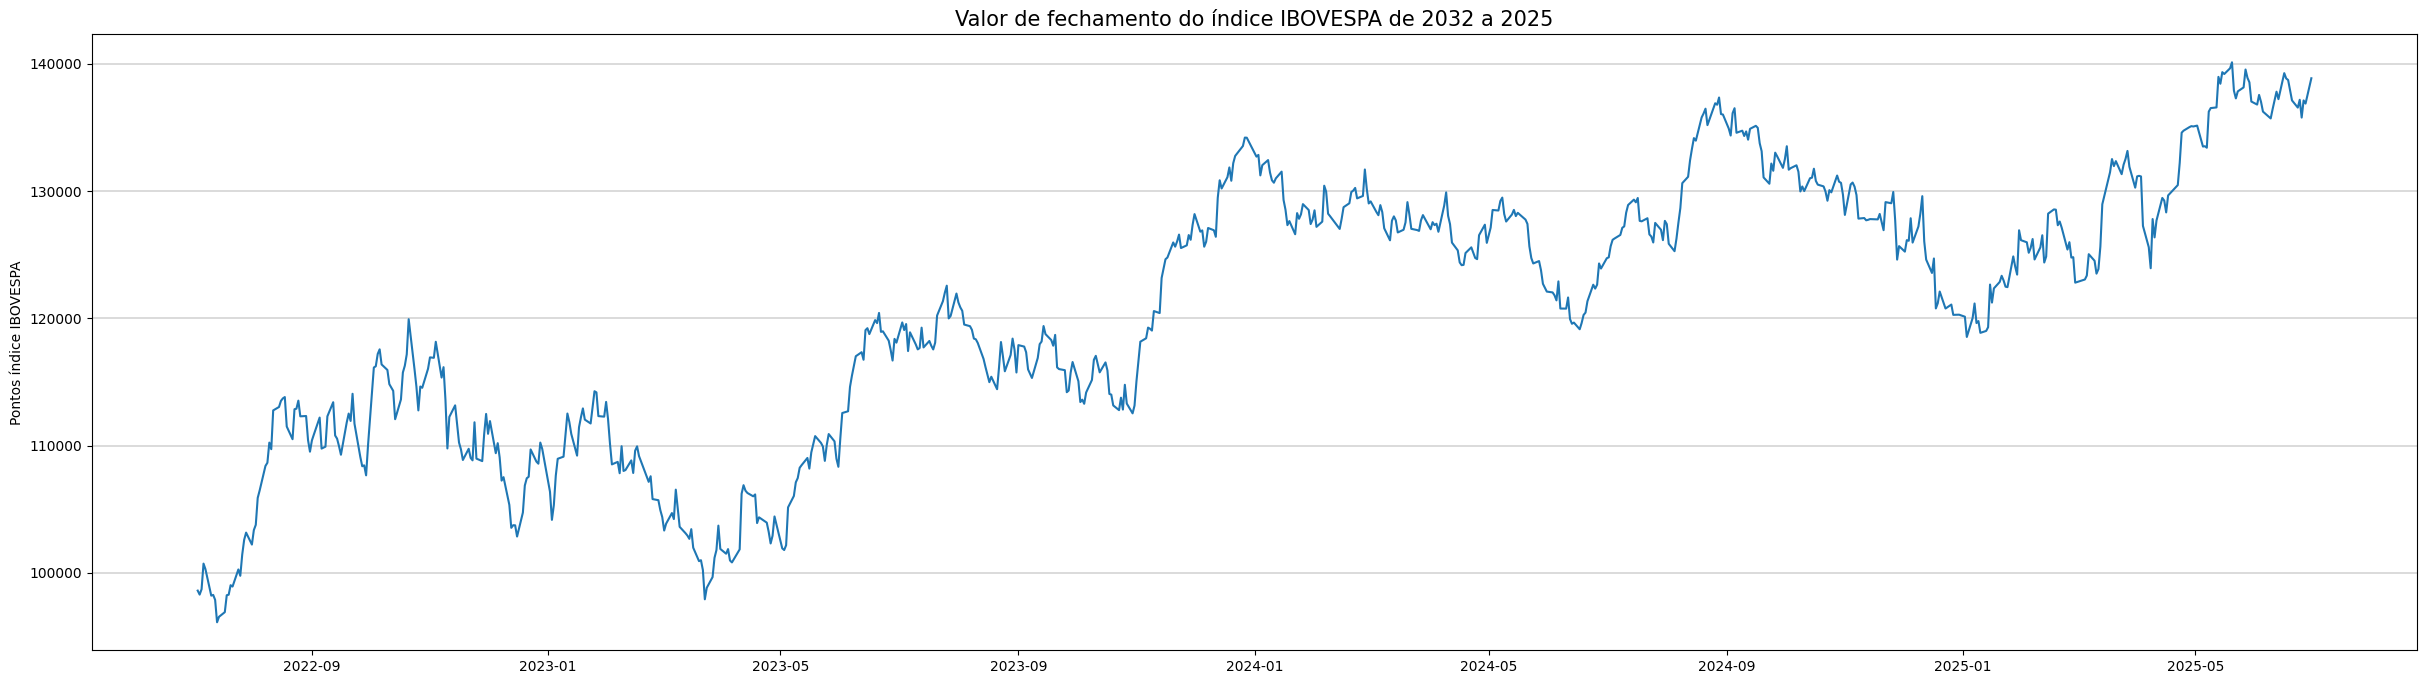

In [46]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df_ibovespa, x='dia', y='fechamento', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Valor de fechamento do índice IBOVESPA de 2032 a 2025', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

🧠 Principais Observações e Tendências Históricas
1. 📉 Queda Recente (Julho/2022)
O índice caiu abaixo de 97.000 pontos, refletindo instabilidade econômica e correções no mercado.

2. 🔁 Consolidação (Ago/2022 – Abr/2023)
O Ibovespa oscilou entre 100.000 e 120.000 pontos, mostrando estabilidade sem perda significativa de suporte.

3. 📈 Alta Sustentada (Jun/2023 em diante)
A partir de junho de 2023, iniciou uma valorização consistente, ultrapassando os 130.000 pontos no início de 2024, impulsionada por melhorias econômicas e maior apetite por risco.

4. ⚖️ Correções e Retomada (2024–2025)
Em 2024, ocorreram correções até cerca de 120.000 pontos, mas a tendência de alta se manteve. Desde março de 2025, o índice retomou força, aproximando-se dos 140.000 pontos.

📌 Conclusão
O Ibovespa apresentou trajetória ascendente, com recuperações rápidas após quedas, indicando maior confiança do mercado diante de desafios econômicos.

# Distribuição das Variações Diárias do IBOVESPA

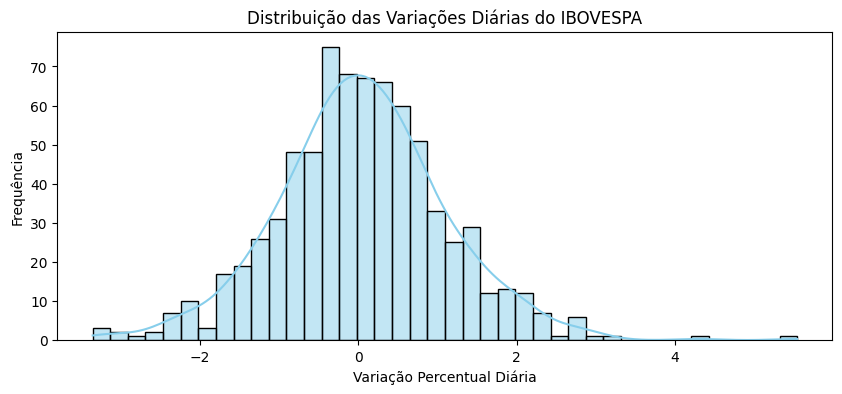

In [47]:
plt.figure(figsize=(10,4))
sns.histplot(df_ibovespa['variacao'], bins=40, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribuição das Variações Diárias do IBOVESPA')
plt.xlabel('Variação Percentual Diária')
plt.ylabel('Frequência')
plt.show()

🧠 Análise da Distribuição
A maioria das variações diárias concentra-se no intervalo entre -2% e +2%.

Há ocorrência de eventos extremos, o que sugere caudas pesadas na distribuição.

A distribuição pode ter assimetria negativa, indicando maior frequência de perdas acentuadas.

A curtose elevada aponta desvio em relação à distribuição normal (maior pico e caudas mais longas).



1. Preparação dos Dados - Fechamento

In [48]:
# Criando um DataFrame com índice datetime baseado na coluna 'dia'
dados_date_index = df_ibovespa[['dia', 'fechamento']].copy()
dados_date_index.index = pd.to_datetime(dados_date_index['dia'], format='%Y-%m-%d')

# Removendo a coluna 'dia' pois ela agora é o índice
dados_date_index.drop(columns=['dia'], inplace=True)

# Ajustando frequência diária e preenchendo valores ausentes com o valor anterior (forward fill)
dados_date_index = dados_date_index.asfreq('D')
dados_date_index.fillna(method='ffill', inplace=True)

# Exibindo o DataFrame
dados_date_index.head(5)


C:\Users\Igor\AppData\Local\Temp\ipykernel_22668\764248274.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados_date_index.fillna(method='ffill', inplace=True)


,fechamento
dia,
2022-07-04,98609.0
2022-07-05,98295.0
2022-07-06,98719.0
2022-07-07,100730.0
2022-07-08,100289.0


2. Resetando o índice e adicionando identificador

In [49]:
# Criando uma nova versão do DataFrame com a coluna 'data' em vez de índice
dados_date_col = dados_date_index.reset_index()
dados_date_col['unique_id'] = 'ibovespa'  # Único identificador da série

# Exibindo o DataFrame
display(dados_date_col)

,dia,fechamento,unique_id
0,2022-07-04,98609.0,ibovespa
1,2022-07-05,98295.0,ibovespa
2,2022-07-06,98719.0,ibovespa
3,2022-07-07,100730.0,ibovespa
4,2022-07-08,100289.0,ibovespa
...,...,...,...
1088,2025-06-26,137114.0,ibovespa
1089,2025-06-27,136866.0,ibovespa
1090,2025-06-28,136866.0,ibovespa
1091,2025-06-29,136866.0,ibovespa


3. Decomposição da Série Temporal - Fechamento

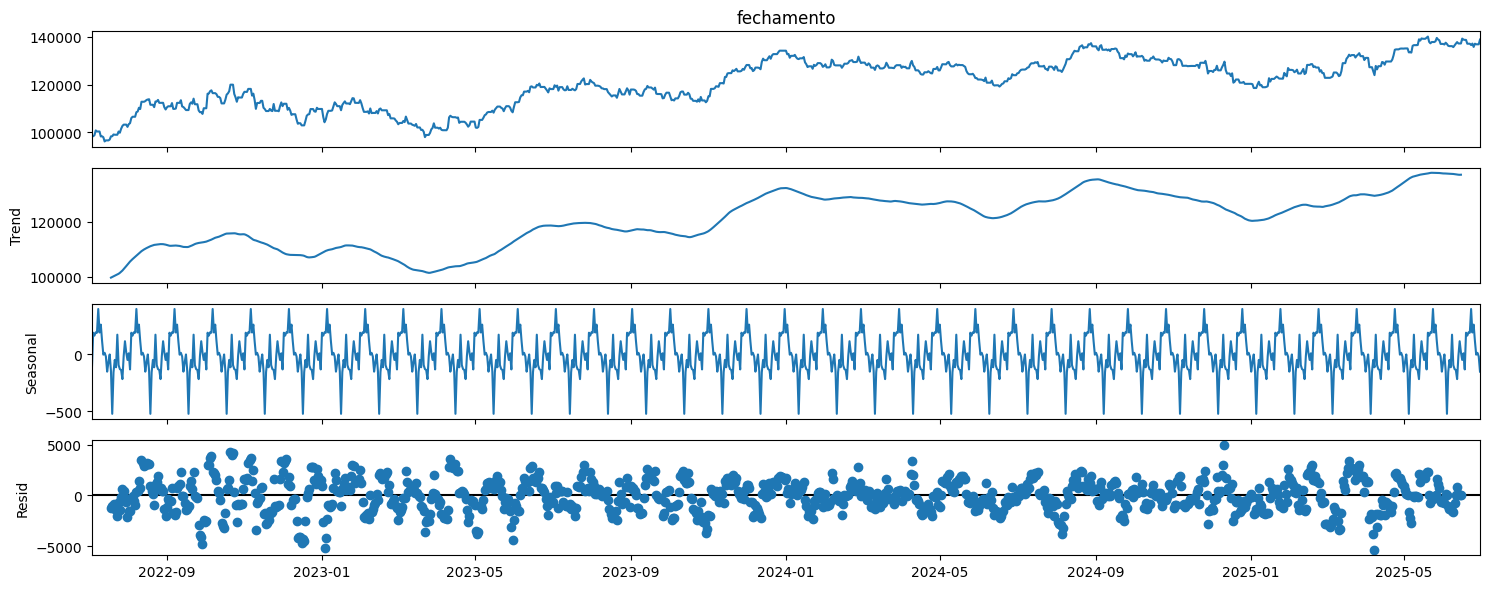

In [50]:
# Decompondo a série temporal de fechamento com modelo aditivo e período mensal (~30 dias)
decomp_fechamento = seasonal_decompose(dados_date_index['fechamento'], model='additive', period=30)

# Plotando os componentes da decomposição
fig = decomp_fechamento.plot()
fig.set_size_inches(15, 6)
plt.tight_layout()
plt.show()

✏️ Observações:
A decomposição revela:

Tendência: crescimento constante até meados de 2024, com leve queda, retomando alta em 2025.

Sazonalidade: ciclos regulares, possivelmente relacionados a padrões mensais ou semanais.

Resíduos: pequenas flutuações que não seguem tendência ou sazonalidade.

4. Preparação dos Dados - Variação

In [51]:
# Repetindo o processo para a coluna de 'variacao'
dados_var_index = df_ibovespa[['dia', 'variacao']].copy()
dados_var_index.index = pd.to_datetime(dados_var_index['dia'], format='%Y-%m-%d')
dados_var_index.drop(columns=['dia'], inplace=True)
dados_var_index = dados_var_index.asfreq('D')
dados_var_index.fillna(method='ffill', inplace=True)

# Exibindo o DataFrame
dados_var_index.head(5)


C:\Users\Igor\AppData\Local\Temp\ipykernel_22668\453667140.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados_var_index.fillna(method='ffill', inplace=True)


,variacao
dia,
2022-07-04,-0.35
2022-07-05,-0.32
2022-07-06,0.43
2022-07-07,2.04
2022-07-08,-0.44


5. Resetando o índice e identificador - Variação


In [52]:
dados_var_col = dados_var_index.reset_index()
dados_var_col['unique_id'] = 'ibovespa'
dados_var_col.head(5)


,dia,variacao,unique_id
0,2022-07-04,-0.35,ibovespa
1,2022-07-05,-0.32,ibovespa
2,2022-07-06,0.43,ibovespa
3,2022-07-07,2.04,ibovespa
4,2022-07-08,-0.44,ibovespa


6. Decomposição da Série Temporal - Variação

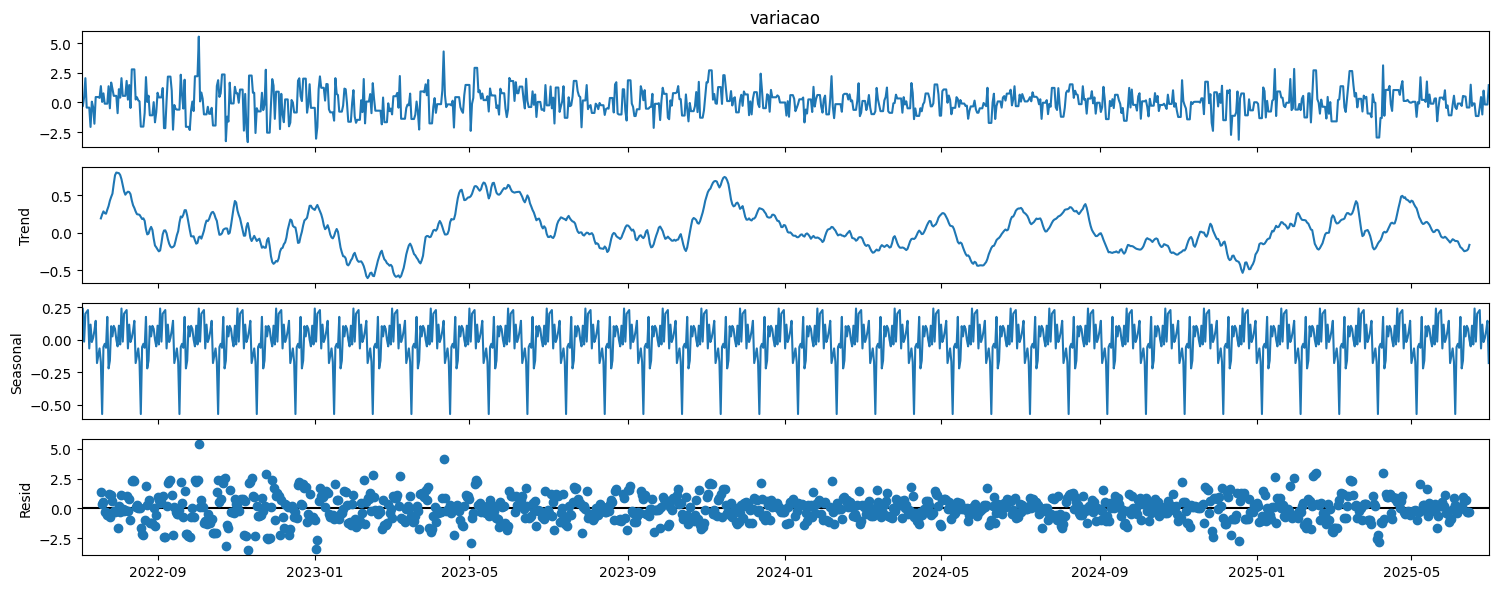

In [53]:
# Decomposição da série de variação
decomp_variacao = seasonal_decompose(dados_var_index['variacao'], model='additive', period=30)

# Plotando os componentes da decomposição
fig = decomp_variacao.plot()
fig.set_size_inches(15, 6)
plt.tight_layout()
plt.show()


✏️ Observações:
A análise da variação diária mostra:

Oscilações regulares com forte sazonalidade.

Picos alternados de alta e baixa.

A tendência global permanece próxima de zero, o que é esperado para séries de variação percentual.

Série temporal:  Ambos graficos de series temporais mostram oscilações com tendencia de alta e sazonalidade regular e ciclica. 

Observa-se uma tendência crescente até meados de 2024, depois uma leve queda e nova alta em 2025.

A sazonalidade forte indicada pode refletir comportamentos previsiveis baseados em dias da semana ou do mes. 


Assim como os os graficos de serie temporal aplicados para o fechamento, a analise baseada na variacao tambem indica forte sazonalidade com oscilações entre picos de baixa e alta, mas mantendo a media global em 0

7. 📉 Teste de Estacionariedade - Dickey-Fuller Aumentado (ADF) Variação

Esse teste verifica se os dados mudam demais ao longo do tempo (não estacionários) ou se seguem um padrão mais estável (estacionários).



In [54]:
#VARIACAO
# Aplicando o teste ADF à série de variação do Ibovespa
variacao_series = df_ibovespa['variacao'].dropna()
adf_result = adfuller(variacao_series)

# Extraindo os resultados
estatistica_teste = adf_result[0]
p_valor = adf_result[1]
n_obs = adf_result[3]
valores_criticos = adf_result[4]

# Exibindo os resultados formatados
print('📉 Teste de Estacionariedade - Dickey-Fuller Aumentado (ADF)')
print(f'Estatística do teste: {estatistica_teste:.4f}')
print(f'Valor-p: {p_valor:.4f}')
print(f'Número de observações: {n_obs}')
print('\nValores críticos:')
for nivel, valor in valores_criticos.items():
    print(f'  {nivel}: {valor:.4f}')


📉 Teste de Estacionariedade - Dickey-Fuller Aumentado (ADF)
Estatística do teste: -26.8690
Valor-p: 0.0000
Número de observações: 745

Valores críticos:
  1%: -3.4392
  5%: -2.8654
  10%: -2.5688



A estatística do teste foi muito menor que os valores críticos (ex: -26.8690 < -3.4392).

O valor-p foi menor que 0,05, indicando alta significância.

✅ Conclusão:
Rejeitamos a hipótese de que a série não é estacionária. Ou seja, a variação do Ibovespa tem um comportamento estável ao longo do tempo, o que é favorável para análises e modelos de previsão. Esse tipo de série tende a produzir resultados mais confiáveis em projeções e estudos de tendência.